In [40]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, precision_recall_fscore_support
from sklearn.linear_model import LogisticRegression
from torch.utils.data import DataLoader, Dataset
import torch
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import Trainer, TrainingArguments
from sklearn.svm import SVC
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import seaborn as sns
import matplotlib.pyplot as plt

In [41]:
df = pd.read_csv('/kaggle/input/chatgpt-user-reviews/CHATGPT.csv')
df.head()

,Review,label
0,up to this point i ’ ve mostly been using chat...,NEGATIVE
1,i ’ ve been a user since it ’ s initial roll o...,NEGATIVE
2,this app would almost be perfect if it wasn ’ ...,NEGATIVE
3,"i recently downloaded the app and overall, it'...",POSITIVE
4,i appreciate the devs implementing siri suppor...,NEGATIVE


In [42]:
df.dropna(inplace=True)

In [43]:
def preprocess(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text.lower())
    filtered_words = [word for word in tokens if word.isalnum() and word not in stop_words]
    return ' '.join(filtered_words)

df['cleaned_review'] = df['Review'].apply(preprocess)
df.head()

,Review,label,cleaned_review
0,up to this point i ’ ve mostly been using chat...,NEGATIVE,point mostly using chatgpt windows desktop usi...
1,i ’ ve been a user since it ’ s initial roll o...,NEGATIVE,user since initial roll waiting mobile applica...
2,this app would almost be perfect if it wasn ’ ...,NEGATIVE,app would almost perfect one little thing sear...
3,"i recently downloaded the app and overall, it'...",POSITIVE,recently downloaded app overall great platform...
4,i appreciate the devs implementing siri suppor...,NEGATIVE,appreciate devs implementing siri support alre...


In [44]:
X = df['cleaned_review']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [45]:
tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [46]:
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

MultinomialNB()

              precision    recall  f1-score   support

    NEGATIVE       0.73      0.90      0.80       249
    POSITIVE       0.82      0.58      0.68       201

    accuracy                           0.76       450
   macro avg       0.78      0.74      0.74       450
weighted avg       0.77      0.76      0.75       450



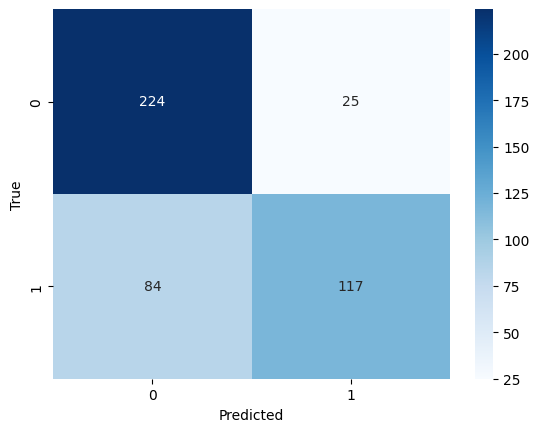

Accuracy: 0.7578


In [47]:
y_pred = nb_model.predict(X_test_tfidf)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.4f}')

In [48]:
lr_model = LogisticRegression(max_iter=1000)
lr_model.fit(X_train_tfidf, y_train)

y_pred_lr = lr_model.predict(X_test_tfidf)

print("Logistic Regression Classification Report:")
print(classification_report(y_test, y_pred_lr))

accuracy_lr = accuracy_score(y_test, y_pred_lr)
print(f'Logistic Regression Accuracy: {accuracy_lr:.4f}')

Logistic Regression Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.75      0.88      0.81       249
    POSITIVE       0.81      0.64      0.71       201

    accuracy                           0.77       450
   macro avg       0.78      0.76      0.76       450
weighted avg       0.78      0.77      0.77       450

Logistic Regression Accuracy: 0.7711


In [49]:
svm_model = SVC(kernel='linear') 
svm_model.fit(X_train_tfidf, y_train)

y_pred_svm = svm_model.predict(X_test_tfidf)

print("SVM Classification Report:")
print(classification_report(y_test, y_pred_svm))

accuracy_svm = accuracy_score(y_test, y_pred_svm)
print(f'SVM Accuracy: {accuracy_svm:.4f}')

SVM Classification Report:
              precision    recall  f1-score   support

    NEGATIVE       0.78      0.85      0.81       249
    POSITIVE       0.79      0.70      0.74       201

    accuracy                           0.78       450
   macro avg       0.78      0.77      0.78       450
weighted avg       0.78      0.78      0.78       450

SVM Accuracy: 0.7822


In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=2)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [51]:
df['label'] = df['label'].map({'NEGATIVE': 0, 'POSITIVE': 1})

In [52]:
class ReviewDataset(Dataset):
    def __init__(self, reviews, labels, tokenizer, max_length):
        self.reviews = reviews
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, index):
        review = self.reviews[index]
        label = self.labels[index]
        
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            truncation=True,
            max_length=self.max_length,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        
        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

max_length = 128
X_train_tokenized = tokenizer(X_train.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=max_length)
X_test_tokenized = tokenizer(X_test.tolist(), padding=True, truncation=True, return_tensors='pt', max_length=max_length)

In [53]:
X_train, X_val, y_train, y_val = train_test_split(df['cleaned_review'], df['label'], test_size=0.2, random_state=42)

train_dataset = ReviewDataset(X_train.tolist(), y_train.tolist(), tokenizer, max_length)
val_dataset = ReviewDataset(X_val.tolist(), y_val.tolist(), tokenizer, max_length)

In [54]:
training_args = TrainingArguments(
    output_dir='./results',
    num_train_epochs=3,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=16,
    evaluation_strategy="epoch",
    logging_dir='./logs',
    logging_steps=10,
)

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, preds, average='binary')
    acc = accuracy_score(labels, preds)
    return {
        'accuracy': acc,
        'f1': f1,
        'precision': precision,
        'recall': recall
    }

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics
)

/opt/conda/lib/python3.10/site-packages/transformers/training_args.py:1545: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [55]:
os.environ["WANDB_DISABLED"] = "true"
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1,Precision,Recall
1,0.427400,0.375113,0.848889,0.828283,0.841026,0.815920
2,0.149900,0.592025,0.855556,0.841076,0.826923,0.855721
3,0.108900,0.586054,0.857778,0.845411,0.821596,0.870647


TrainOutput(global_step=675, training_loss=0.3541691678762436, metrics={'train_runtime': 4192.0552, 'train_samples_per_second': 1.287, 'train_steps_per_second': 0.161, 'total_flos': 355002591444480.0, 'train_loss': 0.3541691678762436, 'epoch': 3.0})

In [56]:
trainer.evaluate()

{'eval_loss': 0.5860540270805359,
 'eval_accuracy': 0.8577777777777778,
 'eval_f1': 0.8454106280193237,
 'eval_precision': 0.8215962441314554,
 'eval_recall': 0.8706467661691543,
 'eval_runtime': 89.8965,
 'eval_samples_per_second': 5.006,
 'eval_steps_per_second': 0.323,
 'epoch': 3.0}

In [57]:
predictions = trainer.predict(val_dataset)
pred_labels = predictions.predictions.argmax(-1)

accuracy = accuracy_score(y_val, pred_labels)
print(f"BERT Accuracy: {accuracy:.4f}")

BERT Accuracy: 0.8578
